Классификация, которую я использовала для размеки:
1. Гендерно-маркированная номинация лица
2. Гендерно-нейтральная номинация лица
3. Дружеское или фамильярное обращение
4. родственник
5. Лицо, состоящее в дружеских отношениях с говорящим
6. Лицо, состоящее в романтических отношениях с говорящим
7. Молодой человек
8. Взрослый человек
9. Пожилой человек
10. Лицо младше или одного возраста с говорящим
0. Воплощение свойств и качеств, присущих данному полу


# Импорты

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
import torch

from datasets import  Dataset, load_metric
from evaluate import load
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.utils.data import WeightedRandomSampler
from transformers import  AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Работа с данными

In [ ]:
df = pd.read_excel('/content/Совсем окончательный датасет.xlsx')
df.head()

,Full context,1 level,conn,marked_text
0,"Если бы не деды, мы бы не собирались сегодня с...",4,neutral,"если бы не [TGT]деды[/TGT], мы бы не собиралис..."
1,Кто начнет первый посылать деда? Я думаю Рамза...,9,neutral,кто начнет первый посылать [TGT]деда[/TGT]? я ...
2,"Но этих мужчин надо слушать, мне таких в жизни...",1,neutral,"но этих [TGT]мужчин[/TGT] надо слушать, мне та..."
3,", даже очень порядочные и вовсе не корыстные д...",10,positive,", даже очень порядочные и вовсе не корыстные [..."
4,"Я знаю, о чем говорю, так как был воспитан мат...",7,neutral,"я знаю, о чем говорю, так как был воспитан мат..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4468 entries, 0 to 4467
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Full context  4468 non-null   object
 1   1 level       4468 non-null   int64 
 2   conn          4468 non-null   object
 3   marked_text   4468 non-null   object
dtypes: int64(1), object(3)
memory usage: 139.8+ KB


In [ ]:
class_counts = df['1 level'].value_counts()
class_counts

,count
1 level,
7,1146
10,880
1,832
3,706
4,212
2,179
9,121
8,115
5,114


In [ ]:
df['conn'].value_counts()

,count
conn,
neutral,3528
positive,648
negative,292


In [ ]:
copy_df = df.copy()

In [ ]:
#перекодирую коннотацию из текста в числа
names={'conn': {'negative': 0, 'neutral': 1, 'positive': 2}}
coded_result = copy_df.replace(names)
coded_result

<ipython-input-9-7f0e2cd3f19d>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  coded_result = copy_df.replace(names)


,Full context,1 level,conn,marked_text
0,"Если бы не деды, мы бы не собирались сегодня с...",4,1,"если бы не [TGT]деды[/TGT], мы бы не собиралис..."
1,Кто начнет первый посылать деда? Я думаю Рамза...,9,1,кто начнет первый посылать [TGT]деда[/TGT]? я ...
2,"Но этих мужчин надо слушать, мне таких в жизни...",1,1,"но этих [TGT]мужчин[/TGT] надо слушать, мне та..."
3,", даже очень порядочные и вовсе не корыстные д...",10,2,", даже очень порядочные и вовсе не корыстные [..."
4,"Я знаю, о чем говорю, так как был воспитан мат...",7,1,"я знаю, о чем говорю, так как был воспитан мат..."
...,...,...,...,...
4463,"мужиками, а не с теми безусыми юнцами , что см...",7,1,"мужиками, а не с теми безусыми [TGT]юнцами[/TG..."
4464,"Я бы даже, честно говоря, усомнилась, что чуви...",10,1,"я бы даже, честно говоря, усомнилась, что [TGT..."
4465,чел сверху мой ребенок,2,1,[TGT]чел[/TGT] сверху мой ребенок
4466,"Эй Бро, нас не испортить деньгами И чтобы не б...",3,2,"эй [TGT]бро[/TGT], нас не испортить деньгами и..."


Номера  классов второго уровння начинаются не с 0, поэтому перекодирую их в номера с 0 по 10. Получилось, что классы с первого по третий сохраняют свое обозначение, а остальные меняются в соответствии со словарем ниже

Пока сделаю самый простой вариант и попробую обучить на классах второго уровня, поэтому удаляю ненужные колонки

In [ ]:
mixed_df = coded_result.drop(['Full context', 'conn'], axis=1)

In [ ]:
mixed_df

,1 level,marked_text
0,4,"если бы не [TGT]деды[/TGT], мы бы не собиралис..."
1,9,кто начнет первый посылать [TGT]деда[/TGT]? я ...
2,1,"но этих [TGT]мужчин[/TGT] надо слушать, мне та..."
3,10,", даже очень порядочные и вовсе не корыстные [..."
4,7,"я знаю, о чем говорю, так как был воспитан мат..."
...,...,...
4463,7,"мужиками, а не с теми безусыми [TGT]юнцами[/TG..."
4464,10,"я бы даже, честно говоря, усомнилась, что [TGT..."
4465,2,[TGT]чел[/TGT] сверху мой ребенок
4466,3,"эй [TGT]бро[/TGT], нас не испортить деньгами и..."


In [ ]:
def tokenize(data, tokenizer):
    return tokenizer(
        data["text"],
        padding="max_length",
        truncation=True,
        max_length=120
    )

In [ ]:
def compute_metrics(eval_pred):
    accuracy_metric = load("accuracy")
    precision_metric = load("precision")
    recall_metric = load("recall")
    f1_metric = load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    calculated_metric = {}
    #отдельно вычисляю accuracy, т.к. для нее average не предусмотрен
    calculated_metric.update(accuracy_metric.compute(predictions=predictions,
                                                     references=labels))

    for metric in [precision_metric, recall_metric, f1_metric]:
      calculated_metric.update(metric.compute(predictions=predictions,
                                              references=labels,
                                              average="weighted"))  #при дисбалансе классов
    #метрики для каждого класса
    unique_labels = np.unique(labels)
    if len(unique_labels) > 2:
        for label in unique_labels:
             calculated_metric.update({
                f"precision_class_{label}": precision_score(
                    labels, predictions, average=None)[label],
                f"recall_class_{label}": recall_score(
                    labels, predictions, average=None)[label],
                f"f1_class_{label}": f1_score(
                    labels, predictions, average=None)[label]
            })
    return calculated_metric


# Предсказание значений

In [ ]:
num_labels =  len(set(mixed_df["1 level"]))
num_labels

11

In [ ]:
model_name = "DeepPavlov/rubert-base-cased-conversational"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="single_label_classification")

Так как датасет у меня небольшой, в качестве обучающей выборки возьму 0.7 от всего датасета, а на  валидационную и тестовую уйдет по 0.15 датасета

In [ ]:
def split_data():
  X_train, X,  y_train, y = train_test_split(mixed_df['marked_text'],
                                                  mixed_df['1 level'],   #столбец, значения в котором хотим  предсказать
                                                  test_size = 0.3,  #доля тестовой выборки от общего числа данных
                                                  random_state = 42,
                                                  stratify = mixed_df['1 level'])  #столбец,  по которому стратифицируем данные

  X_test, X_val, y_test, y_val = train_test_split(X, y,
                                                test_size = 0.5,
                                                random_state = 42,
                                                stratify=y)
  return (
        Dataset.from_dict({"text": X_train.tolist(), "labels": y_train.tolist()}),
        Dataset.from_dict({"text": X_val.tolist(), "labels": y_val.tolist()}),
        Dataset.from_dict({"text": X_test.tolist(), "labels": y_test.tolist()})
    )

Ниже два мейна, которые я запускала с разными гиперпараметрами. Рабочий - первый, результатов второго я не дождалась, так как файнтюнинг, похоже, длился бы 3 часа или больше

In [ ]:
def main():
  X_train, X_val, X_test = split_data()
  tokenized_train = X_train.map(
        lambda x: tokenize(x, tokenizer),
        batched=True)

  tokenized_val = X_val.map(
        lambda x: tokenize(x, tokenizer),
        batched=True)


  tokenized_test = X_test.map(
        lambda x: tokenize(x, tokenizer),
        batched=True)

  training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    learning_rate=5e-5,
    num_train_epochs=3,
    save_strategy="no",
    logging_steps=50)

  trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,)

  print("происходит файнтюнинг")
  trainer.train()

  print("результаты на валидационной выборке")
  val_results = trainer.evaluate()
  for key, value in val_results.items():
      if key.startswith('eval_'):
          print(f"{key[5:]}: {value:.4f}")



  model.save_pretrained("./fine_tuned_model")
  tokenizer.save_pretrained("./fine_tuned_model")
  print("Модель сохранена в fine_tuned_model/")


if __name__ == "__main__":
    main()

Map:   0%|          | 0/3127 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

происходит файнтюнинг


Step,Training Loss
50,1.654600
100,0.894100
150,0.616000
200,0.541900
250,0.361200


результаты на валидационной выборке


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

loss: 0.5247
accuracy: 0.8465
precision: 0.8347
recall: 0.8465
f1: 0.8335
precision_class_0: 0.0000
recall_class_0: 0.0000
f1_class_0: 0.0000
precision_class_1: 0.7770
recall_class_1: 0.8640
f1_class_1: 0.8182
precision_class_2: 0.9412
recall_class_2: 0.5926
f1_class_2: 0.7273
precision_class_3: 0.9352
recall_class_3: 0.9528
f1_class_3: 0.9439
precision_class_4: 0.6136
recall_class_4: 0.8438
f1_class_4: 0.7105
precision_class_5: 0.9286
recall_class_5: 0.7647
f1_class_5: 0.8387
precision_class_6: 0.7000
recall_class_6: 0.4667
f1_class_6: 0.5600
precision_class_7: 0.8978
recall_class_7: 0.9709
f1_class_7: 0.9330
precision_class_8: 0.6429
recall_class_8: 0.5294
f1_class_8: 0.5806
precision_class_9: 0.6667
recall_class_9: 0.2222
f1_class_9: 0.3333
precision_class_10: 0.8722
recall_class_10: 0.8788
f1_class_10: 0.8755
runtime: 298.8984
samples_per_second: 2.2450
steps_per_second: 0.2810
Модель сохранена в fine_tuned_model/


Судя по метрикам, нулевой класс (бывший класс №8) не предсказывается совсем. Это предсказуемо, учитывая, что его экземпляров  не очень много, всего 60. Класс 6 и 8 тоже предсказывается не очень хорошо, но их экземпляров тоже не очень много, около 70-80

In [ ]:
#сохраняю в гугл драйв папку с моделью
!cp -r /content/fine_tuned_model /content/drive/MyDrive/2level_model

In [ ]:
finetuned_model_path = "/content/drive/MyDrive/2level_model"
finetuned_tokenizer_path = "/content/drive/MyDrive/2level_model"
ft_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_path)
ft_tokenizer = AutoTokenizer.from_pretrained(finetuned_tokenizer_path)

In [ ]:
#создание confusion matrix
def plot_confusion_matrix_11_classes(test_dataset):
    trainer = Trainer(model=ft_model)
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = test_dataset["labels"]

    #создаем подписи для классов
    class_names = [f"Class {i}" for i in range(11)]

    #Confusion Matrix
    cm = confusion_matrix(labels, preds)

    #перевожу в проценты
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #настройка размера графика для 11 классов
    plt.figure(figsize=(15, 12))

    #визуализация
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title("Normalized Confusion Matrix (11 классов)", pad=20, fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("True", fontsize=14)

    #сохранение
    plt.savefig("/content/drive/MyDrive/2level_model/confusion_matrix_11_classes.png",
                bbox_inches='tight', dpi=300)
    plt.show()

    #Classification Report
    print(classification_report(labels, preds, target_names=class_names, digits=4))

In [ ]:
X_train, X_val, X_test = split_data()

tokenized_test = X_test.map(
        lambda x: tokenize(x, tokenizer),
        batched=True)

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

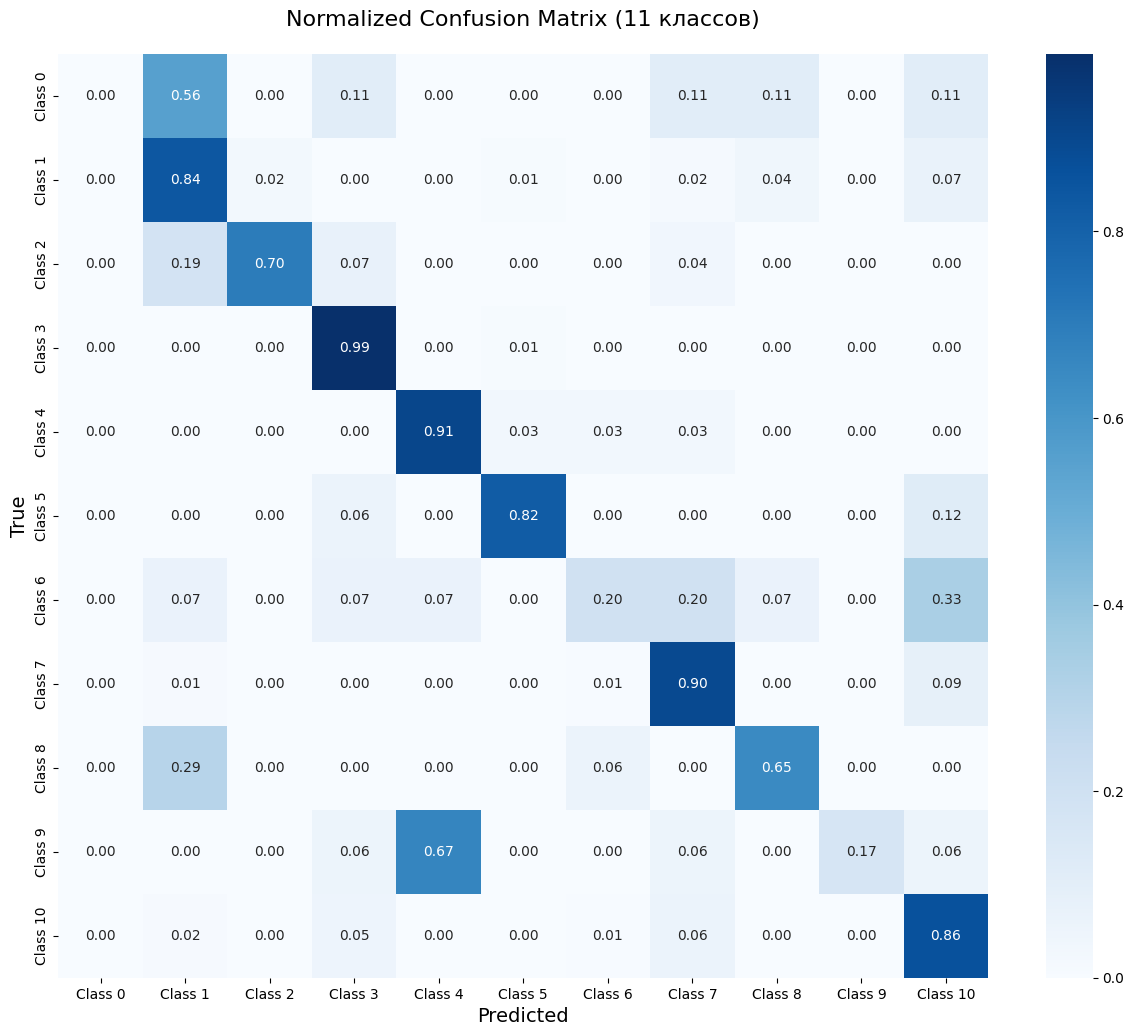

              precision    recall  f1-score   support

     Class 0     0.0000    0.0000    0.0000         9
     Class 1     0.8400    0.8400    0.8400       125
     Class 2     0.8636    0.7037    0.7755        27
     Class 3     0.8898    0.9906    0.9375       106
     Class 4     0.6905    0.9062    0.7838        32
     Class 5     0.8235    0.8235    0.8235        17
     Class 6     0.4286    0.2000    0.2727        15
     Class 7     0.9006    0.8953    0.8980       172
     Class 8     0.6111    0.6471    0.6286        17
     Class 9     1.0000    0.1667    0.2857        18
    Class 10     0.7755    0.8636    0.8172       132

    accuracy                         0.8313       670
   macro avg     0.7112    0.6397    0.6420       670
weighted avg     0.8221    0.8313    0.8159       670



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
plot_confusion_matrix_11_classes(tokenized_test)

## Проверяю работу модели на отдельных  примерах

In [ ]:
def predict_meaning (context: str, lexeme: str, model, tokenizer):
  marked_context = context
  inputs = tokenizer(
        marked_context,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

  with torch.no_grad():
      outputs = model(**inputs)

  probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
  predicted_class = np.argmax(probs)

  result = {"lexeme": lexeme,
            "context": marked_context,
            "predicted_class": int(predicted_class),
            "confidence": float(probs[predicted_class]),
            "all_probs": probs.tolist()
        }
  return result

In [ ]:
res1 = predict_meaning("мы с моей [TGT]чувихой[/TGT] вчера были на концерте", "чувиха", ft_model, ft_tokenizer)
res1

{'lexeme': 'чувиха',
 'context': 'мы с моей [TGT]чувихой[/TGT] вчера были на концерте',
 'predicted_class': 6,
 'confidence': 0.4963742196559906,
 'all_probs': [0.023303261026740074,
  0.008331207558512688,
  0.013161967508494854,
  0.01734939217567444,
  0.03274640813469887,
  0.22214838862419128,
  0.4963742196559906,
  0.013510264456272125,
  0.03718244656920433,
  0.024495111778378487,
  0.11139733344316483]}

In [ ]:
res = predict_meaning("я всегду буду твоим [TGT]бро[/TGT], даже если мы поссоримся", "бро", ft_model, ft_tokenizer)
res

{'lexeme': 'бро',
 'context': 'я всегду буду твоим [TGT]бро[/TGT], даже если мы поссоримся',
 'predicted_class': 5,
 'confidence': 0.7474221587181091,
 'all_probs': [0.01641690917313099,
  0.0053537278436124325,
  0.016155768185853958,
  0.04502401500940323,
  0.03288967162370682,
  0.7474221587181091,
  0.06257285922765732,
  0.012302598915994167,
  0.01913760043680668,
  0.028741955757141113,
  0.013982700183987617]}

In [ ]:
res = predict_meaning("я уже все понял по каждому [TGT]бро[/TGT] и можешь не пытаться меня переубедить", "бро", ft_model, ft_tokenizer)
res


{'lexeme': 'бро',
 'context': 'я уже все понял по каждому [TGT]бро[/TGT] и можешь не пытаться меня переубедить',
 'predicted_class': 5,
 'confidence': 0.49994581937789917,
 'all_probs': [0.009664330631494522,
  0.005353225860744715,
  0.02574688009917736,
  0.37707725167274475,
  0.015643561258912086,
  0.49994581937789917,
  0.01841702312231064,
  0.009905055165290833,
  0.010619190521538258,
  0.016941750422120094,
  0.010685832239687443]}

In [ ]:
res = predict_meaning("будь [TGT]бро[/TGT], помоги нам выиграть в этом конкурсе", "бро", ft_model, ft_tokenizer)
res

{'lexeme': 'бро',
 'context': 'будь [TGT]бро[/TGT], помоги нам выиграть в этом конкурсе',
 'predicted_class': 3,
 'confidence': 0.9502554535865784,
 'all_probs': [0.0022007396910339594,
  0.0023408762644976377,
  0.0047227307222783566,
  0.9502554535865784,
  0.002542430767789483,
  0.026796942576766014,
  0.001727432245388627,
  0.0025522441137582064,
  0.0018159444443881512,
  0.002359483391046524,
  0.002685731276869774]}

In [ ]:
res = predict_meaning("спасибо [TGT]бро[/TGT] за помощь в организации вечеринки", "бро", ft_model, ft_tokenizer)
res

{'lexeme': 'бро',
 'context': 'спасибо [TGT]бро[/TGT] за помощь в организации вечеринки',
 'predicted_class': 5,
 'confidence': 0.7566837072372437,
 'all_probs': [0.012829446233808994,
  0.004919094033539295,
  0.018361374735832214,
  0.08304315060377121,
  0.02181393839418888,
  0.7566837072372437,
  0.03584175184369087,
  0.013454489409923553,
  0.015603067353367805,
  0.023600265383720398,
  0.013849765062332153]}

In [ ]:
res = predict_meaning("ты мой [TGT]бро[/TGT] навсегда, только скажи мне, поедешь ли ты с нами в москву", "бро", ft_model, ft_tokenizer)
res

{'lexeme': 'бро',
 'context': 'ты мой [TGT]бро[/TGT] навсегда, только скажи мне, поедешь ли ты с нами в москву',
 'predicted_class': 5,
 'confidence': 0.7240468859672546,
 'all_probs': [0.014156289398670197,
  0.0047593023627996445,
  0.015411029569804668,
  0.12666209042072296,
  0.023613765835762024,
  0.7240468859672546,
  0.033094730228185654,
  0.01129004918038845,
  0.015769226476550102,
  0.021519044414162636,
  0.009677541442215443]}

In [ ]:
res = predict_meaning("Затем он говорил [TGT]мальчикам[/TGT]: «Именно так работает поэзия.", "мальчик", ft_model, ft_tokenizer)
res

{'lexeme': 'мальчик',
 'context': 'Затем он говорил [TGT]мальчикам[/TGT]: «Именно так работает поэзия.',
 'predicted_class': 7,
 'confidence': 0.9390720725059509,
 'all_probs': [0.006755475886166096,
  0.010759010910987854,
  0.001423006528057158,
  0.0032873046584427357,
  0.002777427202090621,
  0.0020822156220674515,
  0.0036793584004044533,
  0.9390720725059509,
  0.007740988861769438,
  0.0027561483439058065,
  0.01966703310608864]}

In [ ]:
res = predict_meaning("Какой ты гениальный [TGT]мальчик[/TGT]! Я бы ведь сама не догадалась так сделать", "мальчик", ft_model, ft_tokenizer)
res

{'lexeme': 'мальчик',
 'context': 'Какой ты гениальный [TGT]мальчик[/TGT]! Я бы ведь сама не догадалась так сделать',
 'predicted_class': 1,
 'confidence': 0.6126341223716736,
 'all_probs': [0.04534929618239403,
  0.6126341223716736,
  0.019838832318782806,
  0.006305455695837736,
  0.010848878882825375,
  0.005092227831482887,
  0.025478921830654144,
  0.04706500470638275,
  0.08384592831134796,
  0.009192789904773235,
  0.1343485563993454]}

In [ ]:
res = predict_meaning("Хочу оставаться [TGT]женщиной[/TGT], а не превращаться в  сапожника", "женщина", ft_model, ft_tokenizer)
res

{'lexeme': 'женщина',
 'context': 'Хочу оставаться [TGT]женщиной[/TGT], а не превращаться в  сапожника',
 'predicted_class': 1,
 'confidence': 0.5341136455535889,
 'all_probs': [0.15183565020561218,
  0.5341136455535889,
  0.02678024210035801,
  0.008333849720656872,
  0.012775925919413567,
  0.008622677065432072,
  0.0352063812315464,
  0.007089794147759676,
  0.1974697709083557,
  0.011640158481895924,
  0.006131932605057955]}

In [ ]:
res = predict_meaning("мы с [TGT]пацанами[/TGT] часто собираемся вместе.", "пацан", ft_model, ft_tokenizer)
res

{'lexeme': 'пацан',
 'context': 'мы с [TGT]пацанами[/TGT] часто собираемся вместе.',
 'predicted_class': 5,
 'confidence': 0.629729688167572,
 'all_probs': [0.014036008156836033,
  0.005198158789426088,
  0.01485387235879898,
  0.06788753718137741,
  0.02839025855064392,
  0.629729688167572,
  0.07546275854110718,
  0.03796233981847763,
  0.01793031021952629,
  0.03072773665189743,
  0.07782132178544998]}

In [ ]:
res = predict_meaning("мы с моими [TGT]девами[/TGT] пошли вчера вместе за кофе.", "дева", ft_model, ft_tokenizer)
res

{'lexeme': 'дева',
 'context': 'мы с моими [TGT]девами[/TGT] пошли вчера вместе за кофе.',
 'predicted_class': 5,
 'confidence': 0.34430259466171265,
 'all_probs': [0.025276871398091316,
  0.004594802390784025,
  0.011485983617603779,
  0.019700177013874054,
  0.11797424405813217,
  0.34430259466171265,
  0.3311118483543396,
  0.01985246315598488,
  0.03274238854646683,
  0.06234775856137276,
  0.030610816553235054]}

In [ ]:
res = predict_meaning("у [TGT]деда[/TGT] дома или у меня решили собраться.", "дед", ft_model, ft_tokenizer)
res

{'lexeme': 'дед',
 'context': 'у [TGT]деда[/TGT] дома или у меня решили собраться.',
 'predicted_class': 4,
 'confidence': 0.5102699995040894,
 'all_probs': [0.009103644639253616,
  0.002327983733266592,
  0.01629260554909706,
  0.004781557247042656,
  0.5102699995040894,
  0.017220621928572655,
  0.011884263716638088,
  0.007767931558191776,
  0.010020049288868904,
  0.40742528438568115,
  0.002905978122726083]}

In [ ]:
res = predict_meaning("[TGT]дед[/TGT] мне представлялся человеком очень спокойным", "дед", ft_model, ft_tokenizer)
res

{'lexeme': 'дед',
 'context': '[TGT]дед[/TGT] мне представлялся человеком очень спокойным',
 'predicted_class': 4,
 'confidence': 0.5745545625686646,
 'all_probs': [0.009245743975043297,
  0.0024138062726706266,
  0.013660021126270294,
  0.0041765980422496796,
  0.5745545625686646,
  0.01380095910280943,
  0.012117608450353146,
  0.007894687354564667,
  0.0102300513535738,
  0.349001407623291,
  0.002904681023210287]}

In [ ]:
res = predict_meaning("зачем вы так строго с ним, жалко [TGT]деда[/TGT]", "дед", ft_model, ft_tokenizer)
res

{'lexeme': 'дед',
 'context': 'зачем вы так строго с ним, жалко [TGT]деда[/TGT]',
 'predicted_class': 4,
 'confidence': 0.48845550417900085,
 'all_probs': [0.0090573038905859,
  0.0018133054254576564,
  0.017742423340678215,
  0.005637529771775007,
  0.48845550417900085,
  0.028810808435082436,
  0.01819857396185398,
  0.005458164028823376,
  0.01050781924277544,
  0.41090187430381775,
  0.0034167298581451178]}

In [ ]:
res = predict_meaning("тебе [TGT]деды[/TGT] местные ничего не сказали?", "дед", ft_model, ft_tokenizer)
res

{'lexeme': 'дед',
 'context': 'тебе [TGT]деды[/TGT] местные ничего не сказали?',
 'predicted_class': 4,
 'confidence': 0.5011717677116394,
 'all_probs': [0.009170189499855042,
  0.0017091723857447505,
  0.014600301161408424,
  0.004737093113362789,
  0.5011717677116394,
  0.02033855952322483,
  0.013296986930072308,
  0.010335847735404968,
  0.010771840810775757,
  0.41093021631240845,
  0.0029379960615187883]}

In [ ]:
res = predict_meaning("[TGT]мужчина[/TGT] услышал крики и решил помочь несчастным", "мужчина", ft_model, ft_tokenizer)
res

{'lexeme': 'мужчина',
 'context': '[TGT]мужчина[/TGT] услышал крики и решил помочь несчастным',
 'predicted_class': 8,
 'confidence': 0.5032228827476501,
 'all_probs': [0.1119932234287262,
  0.22524642944335938,
  0.018308402970433235,
  0.008114296942949295,
  0.01653105765581131,
  0.01803032122552395,
  0.06569960713386536,
  0.009486035443842411,
  0.5032228827476501,
  0.015764836221933365,
  0.007602892816066742]}

In [ ]:
res = predict_meaning("ради такой [TGT]женщины[/TGT] я был бы готов на многое", "женщина", ft_model, ft_tokenizer)
res

{'lexeme': 'женщина',
 'context': 'ради такой [TGT]женщины[/TGT] я был бы готов на многое',
 'predicted_class': 8,
 'confidence': 0.4775879681110382,
 'all_probs': [0.13898678123950958,
  0.10547489672899246,
  0.02265738882124424,
  0.009267974644899368,
  0.024939915165305138,
  0.03901653364300728,
  0.13993999361991882,
  0.008660354651510715,
  0.4775879681110382,
  0.024729304015636444,
  0.008738824166357517]}

In [ ]:
res = predict_meaning("[TGT]женщина[/TGT] показалась нам очень понимающей", "женщина", ft_model, ft_tokenizer)
res

{'lexeme': 'женщина',
 'context': '[TGT]женщина[/TGT] показалась нам очень понимающей',
 'predicted_class': 8,
 'confidence': 0.4767040014266968,
 'all_probs': [0.15481777489185333,
  0.1918327808380127,
  0.017167292535305023,
  0.00767052685841918,
  0.020182020962238312,
  0.017405161634087563,
  0.07516756653785706,
  0.011257043108344078,
  0.4767040014266968,
  0.019607581198215485,
  0.008188281208276749]}

In [ ]:
res = predict_meaning("вокруг так много красивых [TGT]женщин[/TGT].", "женщина", ft_model, ft_tokenizer)
res

{'lexeme': 'женщина',
 'context': 'вокруг так много красивых [TGT]женщин[/TGT].',
 'predicted_class': 1,
 'confidence': 0.5627352595329285,
 'all_probs': [0.10593535751104355,
  0.5627352595329285,
  0.018072066828608513,
  0.006202970631420612,
  0.009967735037207603,
  0.007614849600940943,
  0.03902048245072365,
  0.006919768173247576,
  0.228210911154747,
  0.008274323306977749,
  0.007046245504170656]}

In [ ]:
res = predict_meaning("[TGT]женщина[/TGT] сказала, что пойдет с нами.", "женщина", ft_model, ft_tokenizer)
res

{'lexeme': 'женщина',
 'context': '[TGT]женщина[/TGT] сказала, что пойдет с нами.',
 'predicted_class': 8,
 'confidence': 0.5791393518447876,
 'all_probs': [0.0977630466222763,
  0.08991461992263794,
  0.020177461206912994,
  0.008306748233735561,
  0.023658957332372665,
  0.02963661029934883,
  0.10934535413980484,
  0.008378452621400356,
  0.5791393518447876,
  0.023309025913476944,
  0.01037030853331089]}

In [ ]:
res = predict_meaning("меня очень тронули слова этого [TGT]деда[/TGT]", "дед", ft_model, ft_tokenizer)
res

{'lexeme': 'дед',
 'context': 'меня очень тронули слова этого [TGT]деда[/TGT]',
 'predicted_class': 4,
 'confidence': 0.6108103394508362,
 'all_probs': [0.01008907426148653,
  0.0031035218853503466,
  0.016006356105208397,
  0.004047203343361616,
  0.6108103394508362,
  0.014088427647948265,
  0.013023972511291504,
  0.006040186155587435,
  0.010248002596199512,
  0.309738427400589,
  0.0028044921346008778]}

In [ ]:
res = predict_meaning("зачем [TGT]герл[/TGT] обижаешь", "герл", ft_model, ft_tokenizer)
res

{'lexeme': 'герл',
 'context': 'зачем [TGT]герл[/TGT] обижаешь',
 'predicted_class': 10,
 'confidence': 0.9265913963317871,
 'all_probs': [0.002468243008479476,
  0.033845894038677216,
  0.003869634820148349,
  0.0063408552668988705,
  0.0009968666126951575,
  0.0038820100016891956,
  0.012640493921935558,
  0.003891577245667577,
  0.004219518043100834,
  0.0012534837005659938,
  0.9265913963317871]}

In [ ]:
res = predict_meaning("[TGT]пацаны[/TGT] это вам во дворе сказали?", "пацан", ft_model, ft_tokenizer)
res

{'lexeme': 'пацан',
 'context': '[TGT]пацаны[/TGT] это вам во дворе сказали?',
 'predicted_class': 3,
 'confidence': 0.9597476124763489,
 'all_probs': [0.0019733922090381384,
  0.002298532286658883,
  0.002651338232681155,
  0.9597476124763489,
  0.0019938081968575716,
  0.013863087631762028,
  0.0016009816899895668,
  0.0056206476874649525,
  0.0015169670805335045,
  0.0017367317341268063,
  0.006996910087764263]}

In [ ]:
res = predict_meaning("такая хот [TGT]герл[/TGT] мне навстречу вышла", "герл", ft_model, ft_tokenizer)
res

{'lexeme': 'герл',
 'context': 'такая хот [TGT]герл[/TGT] мне навстречу вышла',
 'predicted_class': 10,
 'confidence': 0.9606611132621765,
 'all_probs': [0.0016665828879922628,
  0.006967505440115929,
  0.0018682304071262479,
  0.0034568365663290024,
  0.0009528306545689702,
  0.003561554942280054,
  0.012787937186658382,
  0.004301282111555338,
  0.0025266576558351517,
  0.0012493972899392247,
  0.9606611132621765]}

In [ ]:
res = predict_meaning("бар [TGT]герл[/TGT] сегодня не та, что обычно", "герл", ft_model, ft_tokenizer)
res

{'lexeme': 'герл',
 'context': 'бар [TGT]герл[/TGT] сегодня не та, что обычно',
 'predicted_class': 10,
 'confidence': 0.8228392004966736,
 'all_probs': [0.0038982543628662825,
  0.12503287196159363,
  0.007245353888720274,
  0.010638747364282608,
  0.0012578144669532776,
  0.00441722059622407,
  0.012734279967844486,
  0.004686324391514063,
  0.005779273808002472,
  0.0014706806978210807,
  0.8228392004966736]}

In [ ]:
res = predict_meaning("надоела эта клин [TGT]герл[/TGT]", "герл", ft_model, ft_tokenizer)
res

{'lexeme': 'герл',
 'context': 'надоела эта клин [TGT]герл[/TGT]',
 'predicted_class': 10,
 'confidence': 0.6130814552307129,
 'all_probs': [0.005765326786786318,
  0.29413801431655884,
  0.012160689570009708,
  0.03988513723015785,
  0.0016787779750302434,
  0.005283134523779154,
  0.012629321776330471,
  0.006282801739871502,
  0.00729234516620636,
  0.001803137711249292,
  0.6130814552307129]}

In [ ]:
res = predict_meaning("он такой эстетик [TGT]мэн[/TGT]", "мэн", ft_model, ft_tokenizer)
res

{'lexeme': 'мэн',
 'context': 'он такой эстетик [TGT]мэн[/TGT]',
 'predicted_class': 1,
 'confidence': 0.7533949017524719,
 'all_probs': [0.007440492976456881,
  0.7533949017524719,
  0.019001685082912445,
  0.009435460902750492,
  0.0017061533872038126,
  0.0023789035622030497,
  0.007866409607231617,
  0.0035239486023783684,
  0.008518640883266926,
  0.0017024994594976306,
  0.18503092229366302]}

In [ ]:
res = predict_meaning("ему сказал какой-то [TGT]челик[/TGT] давай вместе съездим", "чел", ft_model, ft_tokenizer)
res

{'lexeme': 'чел',
 'context': 'ему сказал какой-то [TGT]челик[/TGT] давай вместе съездим',
 'predicted_class': 1,
 'confidence': 0.691253125667572,
 'all_probs': [0.009271887131035328,
  0.691253125667572,
  0.2598448395729065,
  0.007929504849016666,
  0.003857050323858857,
  0.0024585388600826263,
  0.0034748560283333063,
  0.0018768151057884097,
  0.00787073839455843,
  0.003827899694442749,
  0.008334788493812084]}

In [ ]:
res = predict_meaning("тебе же [TGT]чел[/TGT] из германии кроссы привез", "чел", ft_model, ft_tokenizer)
res

{'lexeme': 'чел',
 'context': 'тебе же [TGT]чел[/TGT] из германии кроссы привез',
 'predicted_class': 2,
 'confidence': 0.7891203165054321,
 'all_probs': [0.011187042109668255,
  0.11496026813983917,
  0.7891203165054321,
  0.008560952730476856,
  0.01455766148865223,
  0.009203560650348663,
  0.010504499077796936,
  0.0028733110520988703,
  0.014437860809266567,
  0.017645934596657753,
  0.006948591209948063]}

In [ ]:
res = predict_meaning("[TGT]чел[/TGT], покупающий плойку в первый раз может и не разберется, ", "чел", ft_model, ft_tokenizer)
res

{'lexeme': 'чел',
 'context': '[TGT]чел[/TGT], покупающий плойку в первый раз может и не разберется, ',
 'predicted_class': 1,
 'confidence': 0.8945075869560242,
 'all_probs': [0.008714420720934868,
  0.8945075869560242,
  0.06682854890823364,
  0.008741517551243305,
  0.0016998931532725692,
  0.0018846811726689339,
  0.0029170492198318243,
  0.000978663214482367,
  0.0078293327242136,
  0.001371831283904612,
  0.004526492673903704]}

In [ ]:
res = predict_meaning("[TGT]чел[/TGT] с какой то сумкой это странно", "чел", ft_model, ft_tokenizer)
res

{'lexeme': 'чел',
 'context': '[TGT]чел[/TGT], с какой то сумкой это странно',
 'predicted_class': 3,
 'confidence': 0.7609202861785889,
 'all_probs': [0.008208331651985645,
  0.13021986186504364,
  0.06252092868089676,
  0.7609202861785889,
  0.0032296839635819197,
  0.013273399323225021,
  0.003287484170868993,
  0.002289244206622243,
  0.00559795368462801,
  0.002989978762343526,
  0.00746289873495698]}

In [ ]:
res = predict_meaning("[TGT]чел[/TGT] не до конца понял этот фильм", "челик", ft_model, ft_tokenizer)
res

{'lexeme': 'челик',
 'context': '[TGT]чел[/TGT] не до конца понял этот фильм',
 'predicted_class': 1,
 'confidence': 0.8911352157592773,
 'all_probs': [0.007623344659805298,
  0.8911352157592773,
  0.0679292157292366,
  0.011977944523096085,
  0.001695779268629849,
  0.0019391136011108756,
  0.0024802940897643566,
  0.0015627914108335972,
  0.006918099708855152,
  0.0013947776751592755,
  0.005343316588550806]}

In [ ]:
res = predict_meaning("[TGT]челик[/TGT] просто все еще бомбит что не получилось", "челик", ft_model, ft_tokenizer)
res

{'lexeme': 'челик',
 'context': '[TGT]челик[/TGT] просто все еще бомбит что не получилось',
 'predicted_class': 3,
 'confidence': 0.8649411201477051,
 'all_probs': [0.004592506680637598,
  0.07066633552312851,
  0.02512032724916935,
  0.8649411201477051,
  0.001930588623508811,
  0.014907901175320148,
  0.0025134936440736055,
  0.0024157168809324503,
  0.003253684611991048,
  0.0018417018000036478,
  0.007816599681973457]}

# Предсказание коннотации

In [ ]:
conn_df = coded_result.drop(['Full context', '1 level'], axis=1)

In [ ]:
conn_df

,conn,marked_text
0,1,"если бы не [TGT]деды[/TGT], мы бы не собиралис..."
1,1,кто начнет первый посылать [TGT]деда[/TGT]? я ...
2,1,"но этих [TGT]мужчин[/TGT] надо слушать, мне та..."
3,2,", даже очень порядочные и вовсе не корыстные [..."
4,1,"я знаю, о чем говорю, так как был воспитан мат..."
...,...,...
4463,1,"мужиками, а не с теми безусыми [TGT]юнцами[/TG..."
4464,1,"я бы даже, честно говоря, усомнилась, что [TGT..."
4465,1,[TGT]чел[/TGT] сверху мой ребенок
4466,2,"эй [TGT]бро[/TGT], нас не испортить деньгами и..."


In [ ]:
num_labels_conn =  len(set(conn_df["conn"]))
num_labels_conn

3

In [ ]:
def split_data_conn():
  X_train, X, y_train, y = train_test_split(conn_df['marked_text'],
                                                  conn_df['conn'],   #столбец, значения в котором хотим  предсказать
                                                  test_size = 0.3,  #доля тестовой выборки от общего числа данных
                                                  random_state = 42,
                                                  stratify = conn_df['conn'])  #столбец,  по которому стратифицируем данные

  X_test, X_val, y_test, y_val = train_test_split(X, y,
                                                test_size = 0.5,
                                                random_state = 42,
                                                stratify=y)
  return (
        Dataset.from_dict({"text": X_train.tolist(), "labels": y_train.tolist()}),
        Dataset.from_dict({"text": X_val.tolist(), "labels": y_val.tolist()}),
        Dataset.from_dict({"text": X_test.tolist(), "labels": y_test.tolist()})
    )

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomTrainer(Trainer):
    def __init__(self, *args, sampler=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.sampler = sampler

    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        if self.sampler is not None:
            return torch.utils.data.DataLoader(
                self.train_dataset,
                batch_size=self.args.train_batch_size,
                sampler=self.sampler,
                collate_fn=self.data_collator,
                drop_last=self.args.dataloader_drop_last,
                num_workers=self.args.dataloader_num_workers,
                pin_memory=self.args.dataloader_pin_memory,
            )
        else:
            return super().get_train_dataloader()

In [ ]:
def main():
  X_train, X_val, X_test = split_data_conn()
  labels = np.array(X_train["labels"])

  class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels)

  class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

  model_name = "DeepPavlov/rubert-base-cased-conversational"
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model_conn = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                  num_labels=3,
    problem_type="single_label_classification")

  model_conn.classifier = nn.Linear(model_conn.config.hidden_size, 3)
  model_conn.loss_fct = nn.CrossEntropyLoss(weight=class_weights)

  sampler = WeightedRandomSampler(weights=class_weights[labels],
                                  num_samples=len(labels),
                                  replacement=True)


  tokenized_train = X_train.map(
        lambda x: tokenize(x, tokenizer),
        batched=True)


  tokenized_val = X_val.map(
        lambda x: tokenize(x, tokenizer),
        batched=True)


  tokenized_test = X_test.map(
        lambda x: tokenize(x, tokenizer),
        batched=True)

  training_args = TrainingArguments(
    output_dir="./balanced_results",
    per_device_train_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=50)

  trainer = CustomTrainer(
        model=model_conn,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        sampler=sampler)

  print("происходит файнтюнинг")
  trainer.train()

  print("результаты на валидационной выборке")
  val_results = trainer.evaluate()
  for key, value in val_results.items():
      if key.startswith('eval_'):
          print(f"{key[5:]}: {value:.4f}")


  model_conn.save_pretrained("./fine_tuned_conn_model_sampling")
  tokenizer.save_pretrained("./fine_tuned_conn_model_sampling")
  print("Модель сохранена в fine_tuned_conn_model_sampling/")


if __name__ == "__main__":
    main()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-conversational and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3127 [00:00<?, ? examples/s]

Map:   0%|          | 0/671 [00:00<?, ? examples/s]

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

происходит файнтюнинг


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Class 0,Recall Class 0,F1 Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Precision Class 2,Recall Class 2,F1 Class 2
1,0.877700,0.615160,0.777943,0.849382,0.777943,0.797624,0.382353,0.590909,0.464286,0.953704,0.777358,0.856549,0.491228,0.865979,0.626866
2,0.286600,0.491746,0.847988,0.856587,0.847988,0.850997,0.454545,0.454545,0.454545,0.927308,0.890566,0.908566,0.652542,0.793814,0.716279
3,0.126500,0.539781,0.842027,0.855803,0.842027,0.847535,0.396226,0.477273,0.432990,0.928571,0.883019,0.905222,0.666667,0.783505,0.720379


результаты на валидационной выборке


loss: 0.5398
accuracy: 0.8420
precision: 0.8558
recall: 0.8420
f1: 0.8475
precision_class_0: 0.3962
recall_class_0: 0.4773
f1_class_0: 0.4330
precision_class_1: 0.9286
recall_class_1: 0.8830
f1_class_1: 0.9052
precision_class_2: 0.6667
recall_class_2: 0.7835
f1_class_2: 0.7204
runtime: 271.0245
samples_per_second: 2.4760
steps_per_second: 0.3100
Модель сохранена в fine_tuned_conn_model_sampling/


In [ ]:
!cp -r /content/fine_tuned_conn_model_sampling /content/drive/MyDrive/conn_sampling__model

In [ ]:
ft_conn_model_path = "/content/drive/MyDrive/conn_sampling__model"
ft_conn_tokenizer_path = "/content/drive/MyDrive/conn_sampling__model"
ft_conn_model = AutoModelForSequenceClassification.from_pretrained(ft_conn_model_path)
ft_conn_tokenizer = AutoTokenizer.from_pretrained(ft_conn_tokenizer_path)

Some weights of the model checkpoint at /content/drive/MyDrive/conn_sampling__model were not used when initializing BertForSequenceClassification: ['loss_fct.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def plot_confusion_matrix(test_dataset):
    trainer = Trainer(model=ft_conn_model)
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = test_dataset["labels"]

    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Class 0", "Class 1", "Class 2"],
                yticklabels=["Class 0", "Class 1", "Class 2"])
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("/content/drive/MyDrive/conn_sampling__model/confusion_matrix.png")
    plt.show()

    print(classification_report(labels, preds, target_names=["Class 0", "Class 1", "Class 2"]))

In [ ]:
X_train, X_val, X_test = split_data_conn()

tokenized_test = X_test.map(
        lambda x: tokenize(x, ft_conn_tokenizer),
        batched=True)

Map:   0%|          | 0/670 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kristinanigamedzanova (kristinanigamedzanova-higher-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


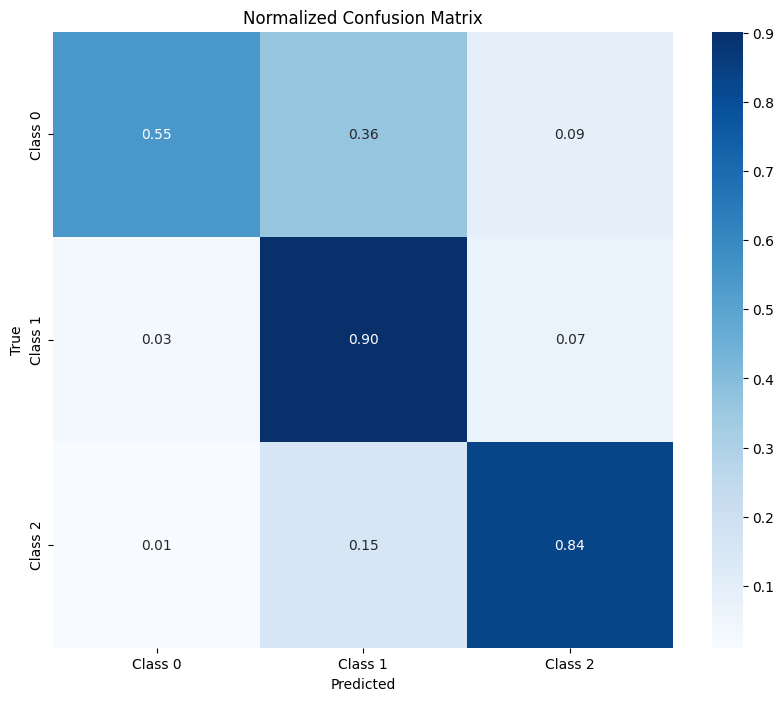

              precision    recall  f1-score   support

     Class 0       0.59      0.55      0.56        44
     Class 1       0.94      0.90      0.92       529
     Class 2       0.67      0.84      0.74        97

    accuracy                           0.87       670
   macro avg       0.73      0.76      0.74       670
weighted avg       0.88      0.87      0.87       670



In [ ]:
plot_confusion_matrix(tokenized_test)

## Проверяю работу модели на отдельных примерах

In [ ]:
conn = predict_meaning("Какой ты гениальный мальчик, я бы ведь мама не догадалась так сделать!", "мальчик", ft_conn_model, ft_conn_tokenizer)
conn

NameError: name 'conn' is not defined

In [ ]:
conn = predict_meaning("ну что ты как девочка? Реши хоть что-то сам и не ной!", "девочка", ft_conn_model, ft_conn_tokenizer)
conn

{'lexeme': 'девочка',
 'context': 'ну что ты как [TGT]девочка[/TGT]? Реши хоть что-то сам и не ной!',
 'predicted_class': 1,
 'confidence': 0.4121318757534027,
 'all_probs': [0.36489707231521606, 0.4121318757534027, 0.222971111536026]}

In [ ]:
conn = predict_meaning("моя герл - огонь, с ней не соскучишься!", "герл", ft_conn_model, ft_conn_tokenizer)
conn

{'lexeme': 'герл',
 'context': 'моя [TGT]герл[/TGT] - огонь, с ней не соскучишься!',
 'predicted_class': 2,
 'confidence': 0.9786319732666016,
 'all_probs': [0.004063241183757782, 0.017304852604866028, 0.9786319732666016]}

In [ ]:
conn = predict_meaning("Чел реально заморочился", "чел", ft_conn_model, ft_conn_tokenizer)
conn

{'lexeme': 'чел',
 'context': 'Чел реально заморочился',
 'predicted_class': 1,
 'confidence': 0.5936833024024963,
 'all_probs': [0.05415108799934387, 0.5936833024024963, 0.3521656394004822]}

# Бейзлайн

In [ ]:
X_train, X_val, X_test, y_train, y_test = split_data()

In [ ]:
class_counts = np.bincount(y_train)
class_probabilities = class_counts / len(y_train)
y_pred_baseline = np.random.choice(len(class_probabilities), size=len(y_test), p=class_probabilities)
baseline_precision = precision_score(y_test, y_pred_baseline, average="weighted")
baseline_f1 = f1_score(y_test, y_pred_baseline, average="weighted")
baseline_recall = recall_score(y_test, y_pred_baseline, average="weighted")

print(f"Precision бейзлайна: {baseline_precision}: Recall {baseline_recall}; f1: {baseline_f1}")

Precision бейзлайна: 0.1771108018829144: Recall 0.1746268656716418; f1: 0.17557638395047473


In [ ]:
X_train, X_val, X_test, y_train, y_test = split_data_conn()

In [ ]:
class_counts = np.bincount(y_train)
class_probabilities = class_counts / len(y_train)
y_pred_baseline = np.random.choice(len(class_probabilities), size=len(y_test), p=class_probabilities)
baseline_precision = precision_score(y_test, y_pred_baseline, average="weighted")
baseline_f1 = f1_score(y_test, y_pred_baseline, average="weighted")
baseline_recall = recall_score(y_test, y_pred_baseline, average="weighted")

print(f"Precision бейзлайна: {baseline_precision}: Recall {baseline_recall}; f1: {baseline_f1}")

Precision бейзлайна: 0.6557164967020104: Recall 0.6462686567164179; f1: 0.6509263061082889
